# Загрязнение атмосферы. Сравнение по странам

## Подготовка

##### Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import folium
import geopandas as gpd
from IPython.display import display, HTML
import sqlite3
from bs4 import BeautifulSoup
from selenium import webdriver

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

##### Скачаем нужные данные

Мы будем использовать данные всемирной организации здравоохранения
- Concentrations of fine particulate matter (PM2.5) (SDGPM25)\
  Загрязнение воздуха твердыми частицами (2010-2019 года)
- Ambient air pollution attributable death rate (per 100 000 population, age-standardized) (AIR_42)\
  Смертность на 100 000 начеления, связанная с загрязнением воздуха, стандартизирована по возрасту (2019 год)

Все индексы можно найти здесь https://www.who.int/data/gho/data/indicators/indicators-index

Нужные данные мы будем запрашивать напрямую с сайта с помощью GHO OData API\
Подробнее здесь https://www.who.int/data/gho/info/gho-odata-api

In [2]:
use_saved_data = False
# Если возникнут проблемы с запросами, вы можете заменить флаг на True,
# тогда будут использованы сохраненные, ранее запрошенные, данные.

def data_request(indicator_code):
    response = requests.get(f'https://ghoapi.azureedge.net/api/{indicator_code}')
    if response.status_code == 200:
        return pd.DataFrame(response.json()['value'])
    else:
        print(f'Ошибка запроса: {response.status_code}, код индикатора: {indicator_code}')

if use_saved_data == False:
    fine_particulate_matter = data_request('SDGPM25')
    death_rate = data_request('AIR_42')
else:
    fine_particulate_matter = pd.read_csv('SDGPM25.csv')
    death_rate = pd.read_csv('project/AIR_42.csv')

Оставшиеся данные лежат в файле co2_data.csv\
Их можно найти здесь https://www.kaggle.com/datasets/kvnxls/co2-emissions-dataset-1750-2020

In [3]:
co2_data = pd.read_csv('co2_data.csv')
co2_data = co2_data[['iso_code', 'country', 'year', 'co2', 'population']]

Нам понадобится информация о странах, регионах и заболеваниях\
Мы будем обращаться к заранее подготовленной базе данных с каталогами catalogs.sqlite

In [4]:
conn = sqlite3.connect("catalogs.sqlite")
cur = conn.cursor()

## Обработка данных

### Данные ВОЗ
В датафреймах ВОЗ есть пустые столбцы и столбцы с единственным уникальным значением (например, типы измерений), удалим их

In [5]:
def drop_useless(data):
    data_new = data.dropna(axis=1, how='all')
    droped_columns = []
    for column in data_new.columns:
        if data_new[column].nunique() == 1:
            droped_columns.append(column)
    data_new = data_new.drop(droped_columns, axis=1)
    return data_new

fine_particulate_matter = drop_useless(fine_particulate_matter)
death_rate = drop_useless(death_rate)

Теперь дообработаем наши датафреймы по очереди:
- отфильтруем
- удалим неинформативные столбцы
- сделаем названия столбцов более простыми и удобными

#### Концентрация твердых частиц в воздухе

In [6]:
fine_particulate_matter.head(2)

,Id,SpatialDimType,SpatialDim,TimeDim,Dim1,Value,NumericValue,Low,High,Date,TimeDimensionValue,TimeDimensionBegin,TimeDimensionEnd
0,29456352,COUNTRY,AFG,2010,CITY,92.79 [66.17-128.44],92.79277,66.16662,128.44125,2022-08-12T08:58:50.06+02:00,2010,2010-01-01T00:00:00+01:00,2010-12-31T00:00:00+01:00
1,29456353,COUNTRY,AFG,2010,TOTL,68.97 [49.48-96.51],68.96605,49.48253,96.51297,2022-08-12T08:58:50.073+02:00,2010,2010-01-01T00:00:00+01:00,2010-12-31T00:00:00+01:00


Нам понадобятся наблюдения по странам

In [7]:
fine_particulate_matter = fine_particulate_matter[fine_particulate_matter['SpatialDimType'] == 'COUNTRY']

fine_particulate_matter = fine_particulate_matter.drop(
    ['Id', 'SpatialDimType', 'Value', 'Date', 'TimeDimensionValue', 'TimeDimensionBegin', 'TimeDimensionEnd'], axis=1)

fine_particulate_matter = fine_particulate_matter.rename(columns={
    'ParentLocationCode': 'Region',
    'SpatialDim': 'Country',
    'TimeDim': 'Year',
    'Dim1': 'Location',
    'NumericValue': 'Value',
    'Low': 'ValueLow',
    'High': 'ValueHigh'
})

fine_particulate_matter.head(3)

,Country,Year,Location,Value,ValueLow,ValueHigh
0,AFG,2010,CITY,92.79277,66.16662,128.44125
1,AFG,2010,TOTL,68.96605,49.48253,96.51297
2,AFG,2010,RUR,61.81464,42.68402,87.77431


#### Смертность
Мы будем рассматривать данные для стран

In [8]:
death_rate.head(3)

,Id,SpatialDimType,SpatialDim,Dim1,Dim2Type,Dim2,Dim3,Value,NumericValue,Low,High,Date
0,29484545,COUNTRY,AFG,BTSX,ENVCAUSE,ENVCAUSE118,None,9 [4-17],9.46660,4.11339,16.66689,2022-08-26T09:13:11.643+02:00
1,29484546,COUNTRY,AFG,BTSX,ENVCAUSE,ENVCAUSE113,None,84 [60-106],83.95202,59.74797,106.37758,2022-08-26T09:13:11.66+02:00
2,29484547,COUNTRY,AFG,BTSX,ENVCAUSE,ENVCAUSE039,None,16 [12-21],15.97986,11.68464,20.60855,2022-08-26T09:13:11.677+02:00


In [9]:
death_rate_countries = death_rate[death_rate['SpatialDimType'] == 'COUNTRY']
death_rate_countries.head(3)

,Id,SpatialDimType,SpatialDim,Dim1,Dim2Type,Dim2,Dim3,Value,NumericValue,Low,High,Date
0,29484545,COUNTRY,AFG,BTSX,ENVCAUSE,ENVCAUSE118,None,9 [4-17],9.46660,4.11339,16.66689,2022-08-26T09:13:11.643+02:00
1,29484546,COUNTRY,AFG,BTSX,ENVCAUSE,ENVCAUSE113,None,84 [60-106],83.95202,59.74797,106.37758,2022-08-26T09:13:11.66+02:00
2,29484547,COUNTRY,AFG,BTSX,ENVCAUSE,ENVCAUSE039,None,16 [12-21],15.97986,11.68464,20.60855,2022-08-26T09:13:11.677+02:00


In [10]:
death_rate_countries = death_rate_countries.drop(
    ['Id', 'SpatialDimType', 'Dim2Type', 'Dim3', 'Value', 'Date'], axis=1)

death_rate_countries = death_rate_countries.rename(columns={
    'SpatialDim': 'Country',
    'Dim1': 'Sex',
    'Dim2': 'Cause',
    'NumericValue': 'Value',
    'Low': 'ValueLow',
    'High': 'ValueHigh'
})

death_rate_countries.head(3)

,Country,Sex,Cause,Value,ValueLow,ValueHigh
0,AFG,BTSX,ENVCAUSE118,9.46660,4.11339,16.66689
1,AFG,BTSX,ENVCAUSE113,83.95202,59.74797,106.37758
2,AFG,BTSX,ENVCAUSE039,15.97986,11.68464,20.60855


### Данные о выбросах CO2
Оставляем данные с 1950 года, удаляем те страны по которым мало данных

In [11]:
co2_data_new = co2_data.dropna(subset=['iso_code'])
co2_data_new = co2_data_new.drop(co2_data_new[co2_data_new['year'].isin(list(range(1750, 1950)))].index)
co2_data_new = co2_data_new.drop(
    co2_data_new[co2_data_new['country'].isin(
        ['Antarctica', 'World', 'Christmas Island', 'Eritrea',
        'Puerto Rico', 'Saint Helena', 'Marshall Islands', 'Saudi Arabia',
        'Timor', 'Eswatini', 'Kuwait', 'Namibia', 'Kosovo']
    )].index)
co2_data_new.head(3)

,iso_code,country,year,co2,population
1,AFG,Afghanistan,1950,0.084,7752117.0
2,AFG,Afghanistan,1951,0.092,7840151.0
3,AFG,Afghanistan,1952,0.092,7935996.0


In [12]:
# Добавим новый столбец - регион мира
# Для этого воспользуемся нашим справочником по странам

region_dict = {}
cur.execute("SELECT id, region_id FROM countries")
result = cur.fetchall()
for row in result:
    country_id, region_id = row[0], row[1]
    if region_id not in region_dict:
        region_dict[region_id] = []
    region_dict[region_id].append(country_id)
    
def fill_regions(row):
    for region in region_dict.keys():
        if row['iso_code'] in region_dict[region]:
            return region
    return np.nan

co2_data_new['region'] = co2_data_new.apply(fill_regions, axis=1)
co2_data_new = co2_data_new.dropna(subset=['region'])
co2_data_new = co2_data_new.sort_values(['country', 'year'])
co2_data_new.head(3)

,iso_code,country,year,co2,population,region
1,AFG,Afghanistan,1950,0.084,7752117.0,EMR
2,AFG,Afghanistan,1951,0.092,7840151.0,EMR
3,AFG,Afghanistan,1952,0.092,7935996.0,EMR


## Визуализация 
Выведем на карту данные о:
- количестве твердых частиц в воздухе (это поможет нам отследить изменения на небольшом отрезке времени, который нам доступен)
- смертности (мы наглядно изучим, какие страны и регионы больше всего страдают от связанных с качеством воздуха заболеваний)

### Загрязнение воздуха на карте мира
Нам потребуются геоданные о странах мира

In [13]:
world = gpd.read_file("countries.json")
#скачали отсюда https://github.com/johan/world.geo.json

Выведем карты с данными за 2013, 2016, 2019 года чтобы увидеть изменения\
Чтобы было нагляднее, мы зафикрисуем цветовую карту одинаковых значениях для всех трех лет

In [14]:
merged_data1 = world.set_index('id').join(fine_particulate_matter[(fine_particulate_matter['Location'] == 'TOTL') & (fine_particulate_matter['Year'] == 2013)].set_index('Country'))
merged_data2 = world.set_index('id').join(fine_particulate_matter[(fine_particulate_matter['Location'] == 'TOTL') & (fine_particulate_matter['Year'] == 2016)].set_index('Country'))
merged_data3 = world.set_index('id').join(fine_particulate_matter[(fine_particulate_matter['Location'] == 'TOTL') & (fine_particulate_matter['Year'] == 2019)].set_index('Country'))

merged_data1 = merged_data1.drop('-99', axis=0)
merged_data2 = merged_data2.drop('-99', axis=0)
merged_data3 = merged_data3.drop('-99', axis=0)

map1 = merged_data1.explore(column="Value", cmap='Reds', vmin=10, vmax=60, zoom_start=1)
map2 = merged_data2.explore(column="Value", cmap='Reds', vmin=10, vmax=60, zoom_start=1)
map3 = merged_data3.explore(column="Value", cmap='Reds', vmin=10, vmax=60, zoom_start=1)

# Отобразим рядом три карты, чтобы можно было нагляднее
html = """
<div style="display:flex">
    <div style="width:33%; margin-right:10px"><h3>{}</h3>{}</div>
    <div style="width:33%; margin-right:10px"><h3>{}</h3>{}</div>
    <div style="width:33%"><h3>{}</h3>{}</div>
</div>
""".format(
    2013, map1._repr_html_(),
    2016, map2._repr_html_(), 
    2019, map3._repr_html_())

display(HTML(html))

При сравнении трех карт мы можем заметить, что в течение десятилетия ситуация поменялась не сильно; хотя улучшения присутствуют\
Два наиболее загрязненных региона - это Африка и Азия, причем только во второй мы видим явную положительную динамику\
Это может объясняться тем, что твердые частицы в Азии антропогенной природы и может применяться политика по их снижению;\
В Африке же, высокие значения могут объясняться естественными причинами: пыльные бури и ветра в жарком климате и при сухой или песчаной почве, с которыми трудно бороться

### Смертность, связанная с загрязнением воздуха
Создадим похожие карты для каждой из болезней-причин смерти, связанных с загрязнением воздуха (обратите внимание: одна из карт показывает данные по всем таким смертям)

In [15]:
cur.execute(f"SELECT * FROM causes")
result = cur.fetchall()
cause_id = [row[0] for row in result]
couse_name = [row[1] for row in result]
dictionary_causes = dict(zip(cause_id, couse_name))


merged_data1 = world.set_index('id').join(death_rate_countries[(death_rate_countries['Cause'] == 'ENVCAUSE118') & (death_rate_countries['Sex'] == 'BTSX')].set_index('Country'))
merged_data2 = world.set_index('id').join(death_rate_countries[(death_rate_countries['Cause'] == 'ENVCAUSE113') & (death_rate_countries['Sex'] == 'BTSX')].set_index('Country'))
merged_data3 = world.set_index('id').join(death_rate_countries[(death_rate_countries['Cause'] == 'ENVCAUSE039') & (death_rate_countries['Sex'] == 'BTSX')].set_index('Country'))
merged_data4 = world.set_index('id').join(death_rate_countries[(death_rate_countries['Cause'] == 'ENVCAUSE114') & (death_rate_countries['Sex'] == 'BTSX')].set_index('Country'))
merged_data5 = world.set_index('id').join(death_rate_countries[(death_rate_countries['Cause'] == 'ENVCAUSE000') & (death_rate_countries['Sex'] == 'BTSX')].set_index('Country'))
merged_data6 = world.set_index('id').join(death_rate_countries[(death_rate_countries['Cause'] == 'ENVCAUSE068') & (death_rate_countries['Sex'] == 'BTSX')].set_index('Country'))
merged_data1 = merged_data1.drop('-99', axis=0)
merged_data2 = merged_data2.drop('-99', axis=0)
merged_data3 = merged_data3.drop('-99', axis=0)
merged_data4 = merged_data4.drop('-99', axis=0)
merged_data5 = merged_data5.drop('-99', axis=0)
merged_data6 = merged_data6.drop('-99', axis=0)

map1 = merged_data1.explore(column="Value", legend=False, cmap='Reds', zoom_start=1)
map2 = merged_data2.explore(column="Value", legend=False, cmap='Reds', zoom_start=1)
map3 = merged_data3.explore(column="Value", legend=False, cmap='Reds', zoom_start=1)
map4 = merged_data4.explore(column="Value", legend=False, cmap='Reds', zoom_start=1)
map5 = merged_data5.explore(column="Value", legend=False, cmap='Reds', zoom_start=1)
map6 = merged_data6.explore(column="Value", legend=False, cmap='Reds', zoom_start=1)

html = """
<div style="display:flex">
    <div style="width:33%; margin-right:10px"><h3>{}</h3>{}</div>
    <div style="width:33%; margin-right:10px"><h3>{}</h3>{}</div>
    <div style="width:33%;"><h3>{}</h3>{}</div>
</div>
<div style="display:flex">
    <div style="width:33%; margin-right:10px"><h3>{}</h3>{}</div>
    <div style="width:33%; margin-right:10px"><h3>{}</h3>{}</div>
    <div style="width:33%"><h3>{}</h3>{}</div>
</div>
""".format(
    dictionary_causes["ENVCAUSE118"], map1._repr_html_(),
    dictionary_causes["ENVCAUSE113"], map2._repr_html_(),
    dictionary_causes["ENVCAUSE039"], map3._repr_html_(),
    dictionary_causes["ENVCAUSE114"], map4._repr_html_(),
    dictionary_causes["ENVCAUSE000"], map5._repr_html_(),
    dictionary_causes["ENVCAUSE068"], map6._repr_html_()
)

display(HTML(html))

Как мы видим в основном от болезней, связанных с загрязнением воздуха, умирают чаще в тех же регионах: в Африке и Азии

## Сравнение значений для стран и регионов
Теперь попробуем поискать закономерности в смертности и выбросах CO2

### Смертность

In [16]:
death_rate_countries.head(3)

,Country,Sex,Cause,Value,ValueLow,ValueHigh
0,AFG,BTSX,ENVCAUSE118,9.46660,4.11339,16.66689
1,AFG,BTSX,ENVCAUSE113,83.95202,59.74797,106.37758
2,AFG,BTSX,ENVCAUSE039,15.97986,11.68464,20.60855


Хочется иметь возможность просматривать данные по разным регионам и причинам, создадим для этого функцию:

In [17]:
def death_rate_plot(Region, Cause):
    cur.execute(f"SELECT id, name FROM countries WHERE region_id = '{Region}'")
    result = cur.fetchall()
    country_iso_list = [row[0] for row in result]
    country_name_list = [row[1] for row in result]
    dictionary_countries = dict(zip(country_iso_list, country_name_list))

    cur.execute(f"SELECT name FROM causes WHERE id = '{Cause}'")
    result = cur.fetchall()
    
    data_men = death_rate_countries[(death_rate_countries['Country'].isin(country_iso_list)) & (death_rate_countries['Cause'] == Cause) & (death_rate_countries['Sex'] == 'MLE')]
    data_women = death_rate_countries[(death_rate_countries['Country'].isin(country_iso_list)) & (death_rate_countries['Cause'] == Cause) & (death_rate_countries['Sex'] == 'FMLE')]
    data_both = death_rate_countries[(death_rate_countries['Country'].isin(country_iso_list)) & (death_rate_countries['Cause'] == Cause) & (death_rate_countries['Sex'] == 'BTSX')]

    data_both = data_both.sort_values('Value')

    fig, axes = plt.subplots(nrows=2, figsize=(24, 16))
    fig.subplots_adjust(hspace=0.6)

    axes[0].scatter(data_men['Country'].map(dictionary_countries), data_men['Value'], color='purple', label='Мужчины', s=150, marker='*', alpha=0.75)
    axes[0].scatter(data_women['Country'].map(dictionary_countries), data_women['Value'], color='orange', label='Женщины', s=150, marker='p', alpha=0.75)
    axes[0].set_xlabel('Страна')
    axes[0].set_ylabel('Смертей на 100 000 человек')
    axes[0].set_title(f'Смертность мужчин и женщин, причина: {dictionary_causes[Cause]}')
    axes[0].legend()
    axes[0].set_xticks(range(len(data_men['Country'])))
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=30, ha='right')

    axes[1].scatter(data_both['Country'].map(dictionary_countries), data_both['ValueHigh'], color='red', label='Максимальное значение смертности', alpha=0.5, s=100)
    axes[1].scatter(data_both['Country'].map(dictionary_countries), data_both['ValueLow'], color='blue', label='Минимальное значение смертности', alpha=0.5, s=100)
    axes[1].scatter(data_both['Country'].map(dictionary_countries), data_both['Value'], color='green', label='Итоговое значение смертности', alpha=0.5, s=100)
    axes[1].set_xlabel('Страна')
    axes[1].set_ylabel('Смертей на 100 000 человек')
    axes[1].set_title('Общие данные о смертности')
    axes[1].legend()
    axes[1].set_xticks(range(len(data_both['Country'])))
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=30, ha='right')

    plt.show()

In [18]:
cur.execute(f"SELECT id, name FROM regions")
result = cur.fetchall()
regions_list = [row[0] for row in result]
regions_name_list = [row[1] for row in result]
dictionary_regions = dict(zip(regions_list, regions_name_list))
print(dictionary_regions)
for cause in dictionary_causes.keys():
    print(cause + ',' + dictionary_causes[cause])

{'AFR': 'Africa', 'AMR': 'Americas', 'EUR': 'Europe', 'WPR': 'Western Pacific', 'SEAR': 'South-East Asia', 'EMR': 'Eastern Mediterranean'}
ENVCAUSE068,Trachea, bronchus, lung cancers
ENVCAUSE039,Lower respiratory infections
ENVCAUSE118,Chronic obstructive pulmonary disease
ENVCAUSE114,Stroke
ENVCAUSE000,Total
ENVCAUSE113,Ischaemic heart disease


Воспользовавшись выведенными выше каталогами, можно посмотреть данные для любого региона и заболевания-причины смерти\
Для этого замените входные параметры ниже

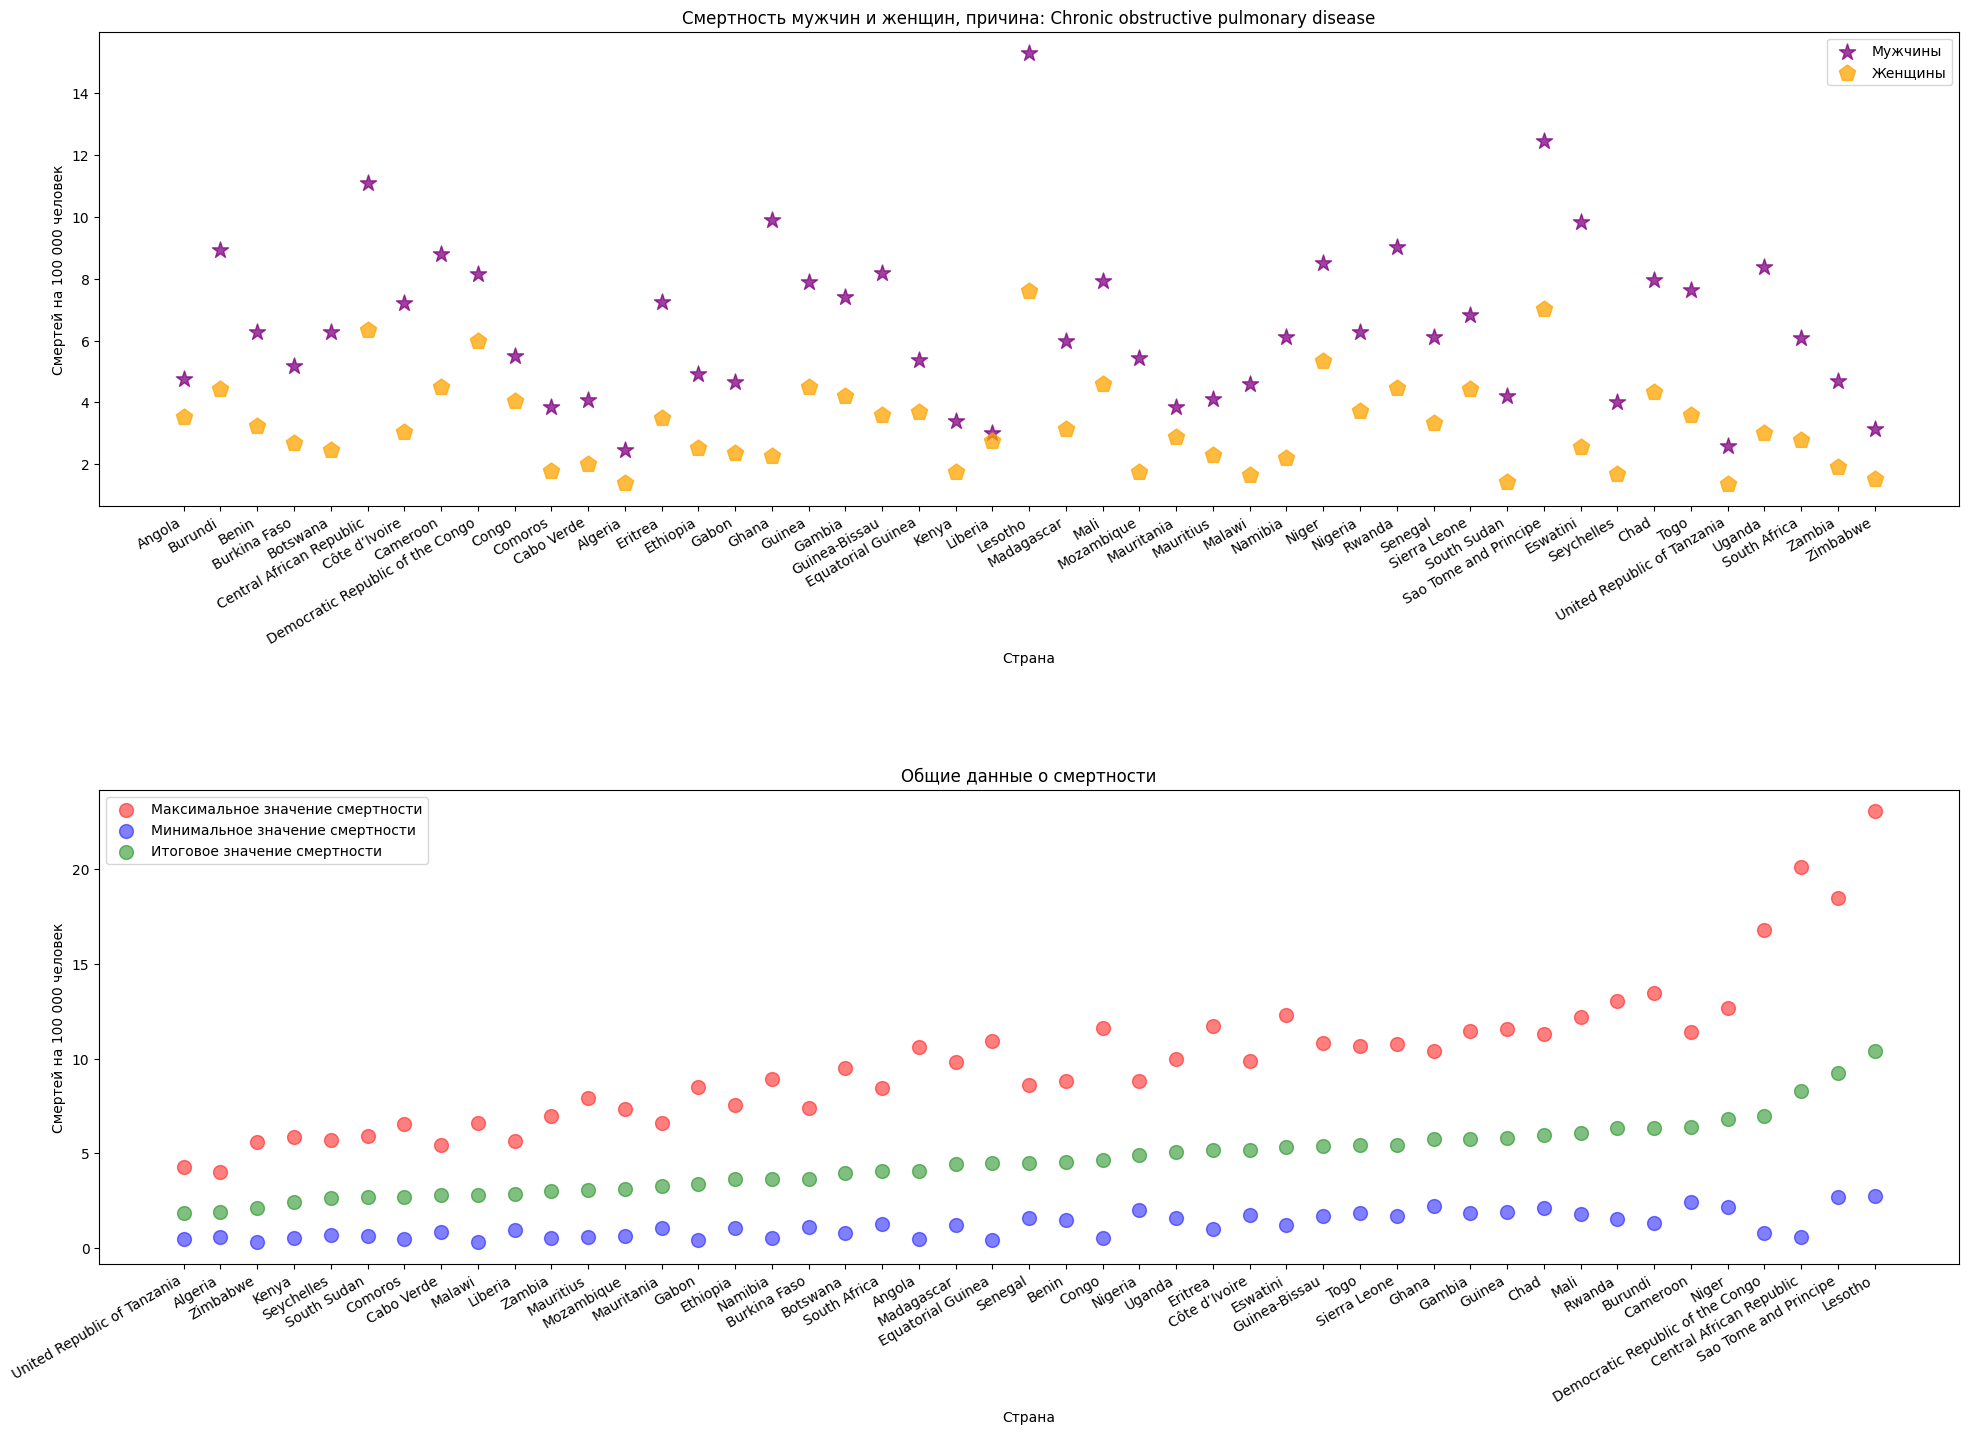

In [19]:
death_rate_plot('AFR', 'ENVCAUSE118')

### Выбросы CO2
Теперь посмотрим на динамику выбросов

In [20]:
co2_data_new.head(3)

,iso_code,country,year,co2,population,region
1,AFG,Afghanistan,1950,0.084,7752117.0,EMR
2,AFG,Afghanistan,1951,0.092,7840151.0,EMR
3,AFG,Afghanistan,1952,0.092,7935996.0,EMR


In [21]:
def co2_plot(region):
    biggest_emissions = co2_data_new[co2_data_new['region'] == region].groupby('country').sum().sort_values('co2', ascending=False)['co2'].head(5).index.tolist()
    data = co2_data_new[co2_data_new['country'].isin(biggest_emissions)]
    
    fig, ax = plt.subplots(figsize=(18, 8))

    for country in biggest_emissions:
        country_data = data[data['country'] == country]
        ax.plot(country_data['year'], country_data['co2'], label=country)

    ax.grid(True, linewidth=0.5, alpha=0.5)
    ax.set_xlabel('Страны')
    ax.set_ylabel('Значения')
    ax.set_title(f'Топ-5 стран по выбросам CO2, {dictionary_regions[region]}')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

In [22]:
print(dictionary_regions)

{'AFR': 'Africa', 'AMR': 'Americas', 'EUR': 'Europe', 'WPR': 'Western Pacific', 'SEAR': 'South-East Asia', 'EMR': 'Eastern Mediterranean'}


Воспользовавшись выведенным выше каталогом, можно посмотреть данные для любого региона\
Для этого замените входной параметр ниже

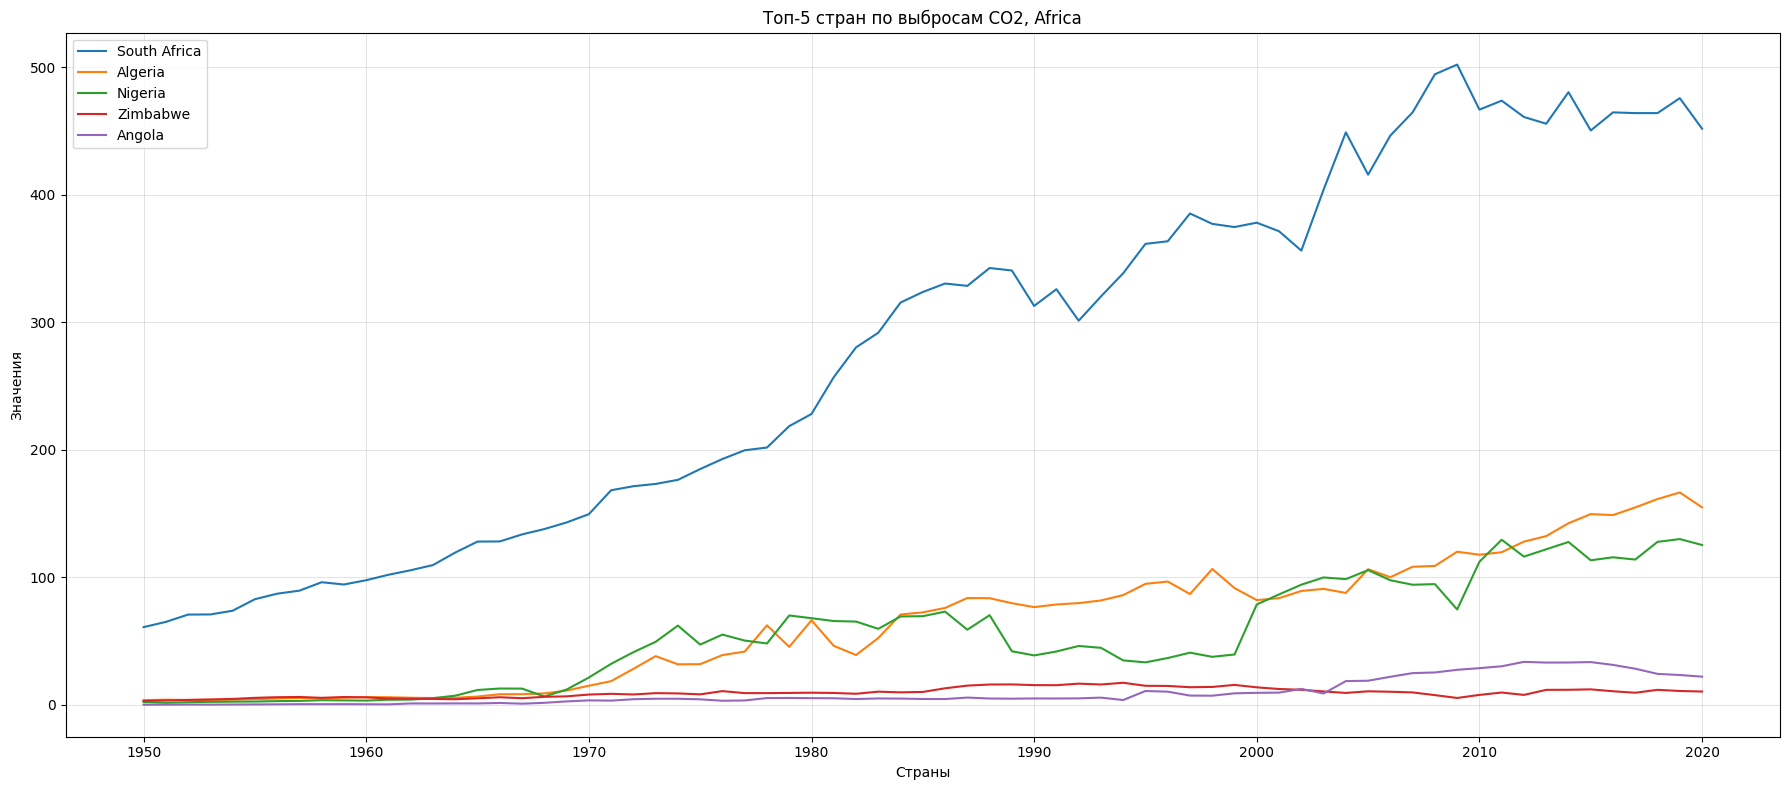

In [23]:
co2_plot('AFR')

Если рассмотреть динамику для разных регионов, то становится понятно, что связи со смертями меньше:
- В Африке величина выбросов небольшая по отношению к другим регионам
- Большие значения выбросов мы можем обнаружить, например, в России и США, которые не так страдают от смертей, связанных с загрязнением воздуха

## Ищем зависимости
Попробуем проследить динамику выбросов CO2 по странам, а так же попытаемся объяснить данные о выбросах

In [24]:
co2_data_new.head(3)

,iso_code,country,year,co2,population,region
1,AFG,Afghanistan,1950,0.084,7752117.0,EMR
2,AFG,Afghanistan,1951,0.092,7840151.0,EMR
3,AFG,Afghanistan,1952,0.092,7935996.0,EMR


In [25]:
# Добавим среднее по выбросам за 15 предыдущих лет, вероятно, от года к году значение выбросов меняется не сильно
co2_data_new['prev_years_avg_co2'] = co2_data_new.groupby('country')['co2'].rolling(15, min_periods=1).mean().reset_index(0, drop=True)
co2_data_new.head(3)

,iso_code,country,year,co2,population,region,prev_years_avg_co2
1,AFG,Afghanistan,1950,0.084,7752117.0,EMR,0.084000
2,AFG,Afghanistan,1951,0.092,7840151.0,EMR,0.088000
3,AFG,Afghanistan,1952,0.092,7935996.0,EMR,0.089333


У нас есть категориальная переменная, которая будет участвовать в предсказании - регион. Закодируем ее

In [26]:
enc = OneHotEncoder()
co2_regions = co2_data_new.copy().reset_index(drop=True)
co2_regions_categorized = pd.DataFrame(enc.fit_transform(co2_regions[['region']]).toarray())
encoded_columns = enc.get_feature_names_out(['region'])
co2_regions_categorized.columns = encoded_columns
co2_regions = co2_regions[['co2', 'population', 'prev_years_avg_co2']].join(co2_regions_categorized)
co2_regions.head(3)

,co2,population,prev_years_avg_co2,region_AFR,region_AMR,region_EMR,region_EUR,region_SEAR,region_WPR
0,0.084,7752117.0,0.084000,0.0,0.0,1.0,0.0,0.0,0.0
1,0.092,7840151.0,0.088000,0.0,0.0,1.0,0.0,0.0,0.0
2,0.092,7935996.0,0.089333,0.0,0.0,1.0,0.0,0.0,0.0


In [27]:
y = co2_regions['co2']
X = np.array(co2_regions.drop('co2', axis=1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777)

model = RandomForestRegressor(random_state=777)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R2:", r2)

MSE: 676.1339796653511
R2: 0.9980040552400498


Теперь мы можем попытаться предсказать значение выбросов,\ 
но природа наших данных такова, что мы скорее будем использовать модель для объяснения уже собранной статистики\
Рассмотрим, какие данные о стране имеют наибольшее значение в объяснении данных о выбросах

In [28]:
feature_importance = model.feature_importances_
features = dict(zip(co2_regions.drop('co2', axis=1).columns, feature_importance))
for feature, importance in features.items():
    importance = round(importance, 3)
    print(f"{feature}: {importance}")

population: 0.074
prev_years_avg_co2: 0.925
region_AFR: 0.0
region_AMR: 0.0
region_EMR: 0.0
region_EUR: 0.0
region_SEAR: 0.0
region_WPR: 0.0


Ожидаемо, среднее за предыдущие года практически полностью определяет выбросы в текущем году\
Попробуем посмотреть, что будет, если убрать этот признак

In [29]:
y = co2_regions['co2']
X = np.array(co2_regions.drop(['co2', 'prev_years_avg_co2'], axis=1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777)

model = RandomForestRegressor(random_state=777)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R2:", r2)

MSE: 18893.544737232485
R2: 0.9442263327250188


In [30]:
feature_importance = model.feature_importances_
features = dict(zip(co2_regions.drop(['co2', 'prev_years_avg_co2'], axis=1).columns, feature_importance))
for feature, importance in features.items():
    importance = round(importance, 3)
    print(f"{feature}: {importance}")

population: 0.782
region_AFR: 0.001
region_AMR: 0.142
region_EMR: 0.001
region_EUR: 0.024
region_SEAR: 0.034
region_WPR: 0.016


In [31]:
conn.close()

Качество модели ухудшилось в несколько десятков раз!\
Тем не менее, мы можем заметить, что население теперь имеет наибольшее значение

## Вывод

Дело в том, что, говоря о  количестве твердых частиц в воздухе, мы должны понимать, что большая их часть может возникать из естественных источников (пыльные бури, лесные пожары, извержения вулканов),\
а выбросы CO2 в очень большой степени антропогенны: например, источниками их могут быть транспорт (автомобили, самолеты) и промышленное проиводство

Сопоставив рассмотренные нами данные с карт и графиков и выводы обученных моделей, мы можем сделать заключение, что:
- с заболеваниями и смертями мы скорее можем связать количество в воздухе твердых частиц, и страдают от этого в основном конкретные регионы: Африка, Азия
- выбросы CO2 имеют долгосрочный эффект и со смертностью напрямую сильно не связаны; крупные государства, выбрасывающие в атмосферу большие объемы CO2 не могут отследить прямого влияния на здоровье населения, это уменьшает стимулы снижать количество выбросов, поэтому необходимо применять международные инструменты для их сокращения

## Как быть нам?
От данных о загрязнении воздуха и смертях, связанных с ним, могло стать некомфортно, поэтому, на всякий случай, давайте загрузим добрых и позитивных статей с сайта Дня Земли\
Надеюсь, они смогут поднять настроение и вдохновить на заботу о нашей планете\
Помните, что действия каждого здесь важны и одновременно с изменением международной политики нужно изменять и собственное поведение в вопросах заботы об окружающей среде

In [32]:
# Сайт блокирует скачивание содержимого страниц с помощью BeautifulSoup, поэтому воспользуемся для начала selenium'ом
# У вас должен быть установлен браузер Chrome

driver = webdriver.Chrome()
url = "https://www.earthday.org/news-and-stories/"
driver.get(url)
html_content = driver.page_source
driver.quit()

soup = BeautifulSoup(html_content, 'html.parser')
news_part = soup.find('div', class_='news-list my-lg-5')
news_list = news_part.find_all('h4')

news_count = 0
for news in news_list:
    title = news.text.strip()
    link = news.find('a')['href']
    print(f"{title}\n{link}\n")
    news_count += 1
    if news_count == 5:    # 5 статей будет достаточно
        break

World Environment Day: Protecting our Planet One Action at a Time
https://www.earthday.org/world-environment-day-protecting-our-planet-one-action-at-a-time/

This Summer, Switch to Sustainable Swimwear
https://www.earthday.org/this-summer-tell-your-favorite-swimwear-brand-to-cut-out-the-plastic/

Sacred Earth: How 18,000 Red-Clad Devotees Transformed Earth Day into a Spiritual Awakening
https://www.earthday.org/sacred-earth-how-18000-red-clad-devotees-transformed-earth-day-into-a-spiritual-awakening/

How to Enjoy Coffee in a Greener Way
https://www.earthday.org/how-to-enjoy-coffee-in-a-greener-way/

Honey Heists and Honey Fraud
https://www.earthday.org/honey-heists-and-honey-fraud/



## The End